In [1]:
# for data load
import os
import numpy as np
import nibabel as nib
from scipy.spatial import procrustes
from sklearn.decomposition import PCA
# for reading and processing images
import imageio
from PIL import Image
import skimage.transform as skTrans
# for visualizations
import matplotlib.pyplot as plt
# for bulding and running deep learning model
import tensorflow as tf
from tensorflow.keras.layers import Input
from tensorflow.keras.layers import Conv2D
from tensorflow.keras.layers import MaxPooling2D
from tensorflow.keras.layers import Dropout
from tensorflow.keras.layers import BatchNormalization
from tensorflow.keras.layers import Conv2DTranspose
from tensorflow.keras.layers import concatenate
from tensorflow.keras.losses import binary_crossentropy
from sklearn.model_selection import train_test_split

In [2]:
image_dir = r"C:\\Users\\Dharuneswar Kumar\\Downloads\\Mini project\\img"
#output_dir =r"/content/drive/MyDrive/Dataset/output"
mask_dir = r"C:\\Users\\Dharuneswar Kumar\\Downloads\\Mini project\\masks"


In [3]:
def rotate_volume(data):
    # Rotate volume by 90 degrees to the right
    rotated_data = np.rot90(data, k=-1)
    return rotated_data

In [4]:
'''image_files = os.listdir(image_dir)
mask_files = os.listdir(mask_dir)
 # Process each slice individually
for img_file,mask_file in zip(image_files,mask_files):
    img_path = os.path.join(image_dir, img_file)
    mask_path = os.path.join(mask_dir, mask_file)
    # Load the image
    img = nib.load(img_path)
    mask_img = nib.load(mask_path).get_fdata()
    imgdata=img.get_fdata()
    if imgdata is None:
        print(f"Error loading image: {img_path}")
        continue  # Skip to the next image
    # Rotate the volume
    rotated_data = rotate_volume(imgdata)
    rotated_mask_img = rotate_volume(mask_img)
    # Get depth (number of slices)
    depth = rotated_data.shape[2]
    # Process each slice individually

    processed_ct_img = np.zeros_like(rotated_data)
    for i in range(60,80):
        img_slice = rotated_data[:,:,i]
        mask_slice = rotated_mask_img[:,:,i]
        masked_ct_slice = np.where(mask_slice > 0, img_slice, 0)
        processed_ct_img[:,:,i] = masked_ct_slice
'''


'image_files = os.listdir(image_dir)\nmask_files = os.listdir(mask_dir)\n # Process each slice individually\nfor img_file,mask_file in zip(image_files,mask_files):\n    img_path = os.path.join(image_dir, img_file)\n    mask_path = os.path.join(mask_dir, mask_file)\n    # Load the image\n    img = nib.load(img_path)\n    mask_img = nib.load(mask_path).get_fdata()\n    imgdata=img.get_fdata()\n    if imgdata is None:\n        print(f"Error loading image: {img_path}")\n        continue  # Skip to the next image\n    # Rotate the volume\n    rotated_data = rotate_volume(imgdata)\n    rotated_mask_img = rotate_volume(mask_img)\n    # Get depth (number of slices)\n    depth = rotated_data.shape[2]\n    # Process each slice individually\n\n    processed_ct_img = np.zeros_like(rotated_data)\n    for i in range(60,80):\n        img_slice = rotated_data[:,:,i]\n        mask_slice = rotated_mask_img[:,:,i]\n        masked_ct_slice = np.where(mask_slice > 0, img_slice, 0)\n        processed_ct_img

In [5]:
def LoadData (path1, path2):
    """
    Looks for relevant filenames in the shared path
    Returns 2 lists for original and masked files respectively

    """
    # Read the images folder like a list
    image_dataset = os.listdir(path1)
    mask_dataset = os.listdir(path2)
    # Make a list for images and masks filenames
    orig_img = []
    mask_img = []
    for file in image_dataset:
        orig_img.append(file)
    for file in mask_dataset:
        mask_img.append(file)
    return orig_img, mask_img

In [6]:
def PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2):
    """
    Processes the images and mask present in the shared list and path
    Returns a NumPy dataset with images as 3-D arrays of desired size
    Please note the masks in this dataset have only one channel
    """
    # Pull the relevant dimensions for image and mask
    m = len(img)                     # number of images
    i_h,i_w,i_c = target_shape_img   # pull height, width, and channels of image
    m_h,m_w,m_c = target_shape_mask  # pull height, width, and channels of mask
    # Define X and Y as number of images along with shape of one image
    X = np.zeros((m,i_h,i_w,i_c), dtype=np.float32)
    y = np.zeros((m,m_h,m_w,m_c), dtype=np.int32)
    # Resize images and masks
    for index,file in enumerate(img):
        path = os.path.join(path1, file)
        single_img = nib.load(path).get_fdata()
        index =img.index(file)
        single_img_max_proj = np.max(single_img, axis=2)
        # convert image into an array of desired shape (3 channels)
        single_img = skTrans.resize(single_img_max_proj, (i_h,i_w), order=1, preserve_range=True)
        # Create artificial channels by duplicating the single channel across all three channels
        single_img = np.stack((single_img,) * 3, axis=-1)
        # Normalize pixel values to be in the range [0, 1]

        X[index] = single_img/255.0

        # convert mask into an array of desired shape (1 channel)
        single_mask_ind = mask[index]
        path = os.path.join(path2, single_mask_ind)
        single_mask = nib.load(path).get_fdata()
        single_mask_max_proj = np.max(single_img, axis=2)
        single_mask = skTrans.resize(single_mask_max_proj,(m_h, m_w), order=1, preserve_range=True)
        single_mask = np.expand_dims(single_mask, axis=-1)
        single_mask = single_mask - 1 # to ensure classes #s start from 0
        y[index] = single_mask
    return X, y

In [7]:
def EncoderMiniBlock(inputs, n_filters=32, dropout_prob=0.3, max_pooling=True):
    """
    This block uses multiple convolution layers, max pool, relu activation to create an architecture for learning.
    Dropout can be added for regularization to prevent overfitting.
    The block returns the activation values for next layer along with a skip connection which will be used in the decoder
    """
    # Add 2 Conv Layers with relu activation and HeNormal initialization using TensorFlow
    # Proper initialization prevents from the problem of exploding and vanishing gradients
    # 'Same' padding will pad the input to conv layer such that the output has the same height and width (hence, is not reduced in size)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(inputs)
    conv = Conv2D(n_filters,
                  3,   # Kernel size
                  activation='relu',
                  padding='same',
                  kernel_initializer='HeNormal')(conv)

    # Batch Normalization will normalize the output of the last layer based on the batch's mean and standard deviation
    conv = BatchNormalization()(conv, training=False)

    # In case of overfitting, dropout will regularize the loss and gradient computation to shrink the influence of weights on output
    if dropout_prob > 0:
        conv = tf.keras.layers.Dropout(dropout_prob)(conv)

    # Pooling reduces the size of the image while keeping the number of channels same
    # Pooling has been kept as optional as the last encoder layer does not use pooling (hence, makes the encoder block flexible to use)
    # Below, Max pooling considers the maximum of the input slice for output computation and uses stride of 2 to traverse across input image
    if max_pooling:
        next_layer = tf.keras.layers.MaxPooling2D(pool_size = (2,2))(conv)
    else:
        next_layer = conv

    # skip connection (without max pooling) will be input to the decoder layer to prevent information loss during transpose convolutions
    skip_connection = conv

    return next_layer, skip_connection

In [8]:
def DecoderMiniBlock(prev_layer_input, skip_layer_input, n_filters=32):
    """
    Decoder Block first uses transpose convolution to upscale the image to a bigger size and then,
    merges the result with skip layer results from encoder block
    Adding 2 convolutions with 'same' padding helps further increase the depth of the network for better predictions
    The function returns the decoded layer output
    """
    # Start with a transpose convolution layer to first increase the size of the image
    up = Conv2DTranspose(
                 n_filters,
                 (3,3),    # Kernel size
                 strides=(2,2),
                 padding='same')(prev_layer_input)

    # Merge the skip connection from previous block to prevent information loss
    merge = concatenate([up, skip_layer_input], axis=3)

    # Add 2 Conv Layers with relu activation and HeNormal initialization for further processing
    # The parameters for the function are similar to encoder
    conv = Conv2D(n_filters,
                 3,     # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(merge)
    conv = Conv2D(n_filters,
                 3,   # Kernel size
                 activation='relu',
                 padding='same',
                 kernel_initializer='HeNormal')(conv)
    return conv

In [9]:
def UNetCompiled(input_size=(128, 128, 3), n_filters=32, n_classes=3):



    """
    Combine both encoder and decoder blocks according to the U-Net research paper
    Return the model as output
    """
    # Input size represent the size of 1 image (the size used for pre-processing)
    inputs = Input(input_size)

    # Encoder includes multiple convolutional mini blocks with different maxpooling, dropout and filter parameters
    # Observe that the filters are increasing as we go deeper into the network which will increasse the # channels of the image
    cblock1 = EncoderMiniBlock(inputs, n_filters,dropout_prob=0, max_pooling=True)
    cblock2 = EncoderMiniBlock(cblock1[0],n_filters*2,dropout_prob=0, max_pooling=True)
    cblock3 = EncoderMiniBlock(cblock2[0], n_filters*4,dropout_prob=0, max_pooling=True)
    cblock4 = EncoderMiniBlock(cblock3[0], n_filters*8,dropout_prob=0.3, max_pooling=True)
    cblock5 = EncoderMiniBlock(cblock4[0], n_filters*16, dropout_prob=0.3, max_pooling=False)

    # Decoder includes multiple mini blocks with decreasing number of filters
    # Observe the skip connections from the encoder are given as input to the decoder
    # Recall the 2nd output of encoder block was skip connection, hence cblockn[1] is used
    ublock6 = DecoderMiniBlock(cblock5[0], cblock4[1],  n_filters * 8)
    ublock7 = DecoderMiniBlock(ublock6, cblock3[1],  n_filters * 4)
    ublock8 = DecoderMiniBlock(ublock7, cblock2[1],  n_filters * 2)
    ublock9 = DecoderMiniBlock(ublock8, cblock1[1],  n_filters)

    # Complete the model with 1 3x3 convolution layer (Same as the prev Conv Layers)
    # Followed by a 1x1 Conv layer to get the image to the desired size.
    # Observe the number of channels will be equal to number of output classes
    conv9 = Conv2D(n_filters,
                 3,
                 activation='relu',
                 padding='same',
                 kernel_initializer='he_normal')(ublock9)

    conv10 = Conv2D(n_classes, 1, padding='same')(conv9)

    # Define the model
    model = tf.keras.Model(inputs=inputs, outputs=conv10)

    return model

(512, 512, 350)
(512, 512, 350)


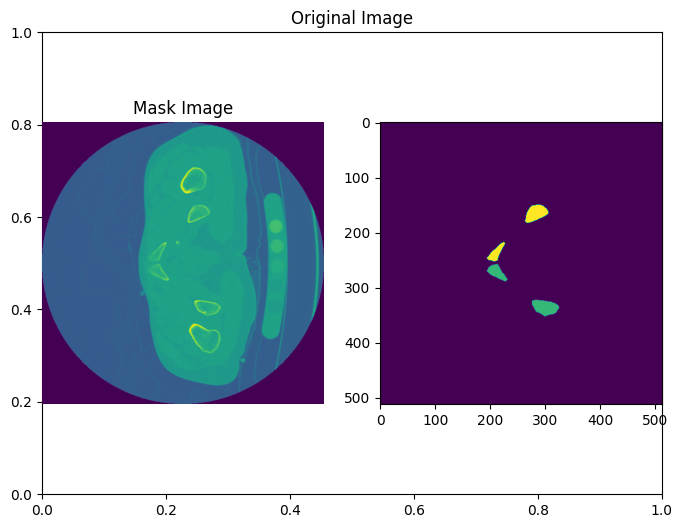

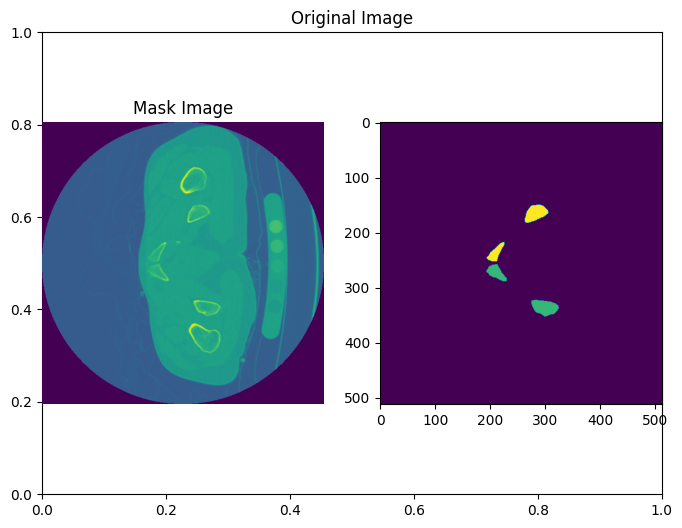

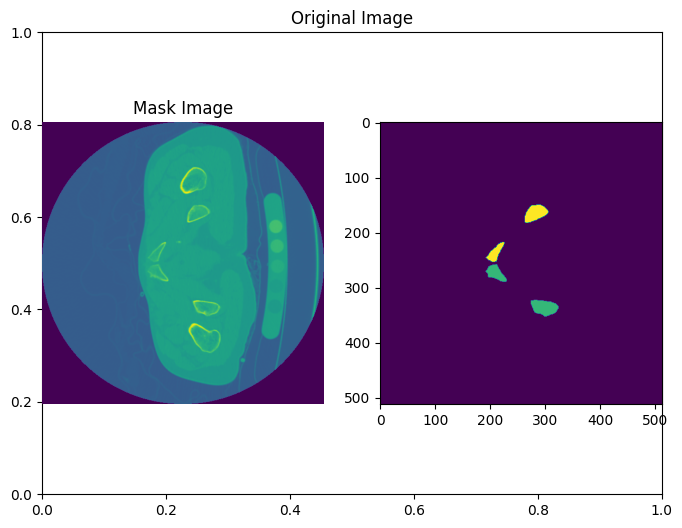

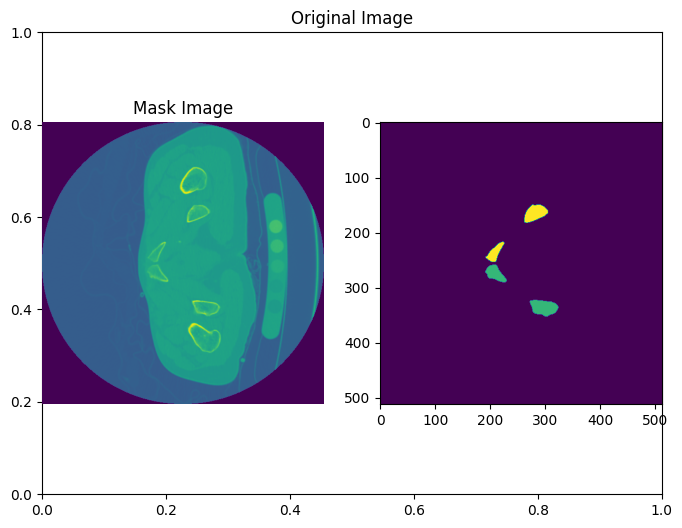

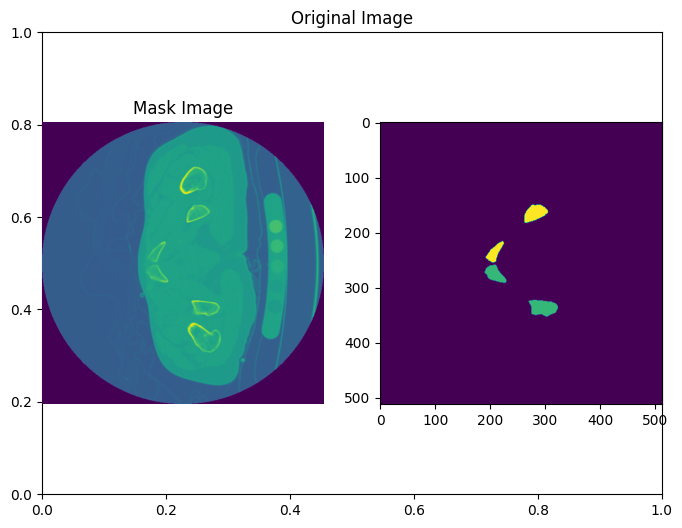

In [10]:
""" Load Train Set and view some examples """
# Call the apt function
path1 = image_dir
path2 = mask_dir
img, mask = LoadData (path1, path2)

# View an example of image and corresponding mask
show_images = 1
for i in range(show_images):
    img_view = nib.load(os.path.join(path1,img[i])).get_fdata()
    mask_view = nib.load(os.path.join(path2,mask[i])).get_fdata()
    print(img_view.shape)
    print(mask_view.shape)
    for i in range(60,65):
        img_slice = img_view[:,:,i]
        mask_slice = mask_view[:,:,i]
        plt.figure(figsize=(8, 6))
        plt.title('Original Image')
        plt.subplot(1, 2, 1)
        plt.imshow(img_slice)
        plt.axis('off')

        plt.title('Mask Image')
        plt.subplot(1, 2, 2)
        plt.imshow(mask_slice)

        plt.show()


In [11]:
# Define the desired shape
target_shape_img = [128, 128, 3]
target_shape_mask = [128, 128, 1]

# Process data using apt helper function
X, y = PreprocessData(img, mask, target_shape_img, target_shape_mask, path1, path2)

# QC the shape of output and classes in output dataset
print("X Shape:", X.shape)
print("Y shape:", y.shape)

# Sample input array
label_values = np.unique(y)
# Convert each value in the array to fall within the range [0, 3)

updclass=[]
for a in range(0,len(img)):
  for b in range(128):
    for c in range(128):
      for d in range(1):
        if y[a,b,c,d]<0:
          y[a,b,c,d]=0
        elif y[a,b,c,d]>=0 and y[a,b,c,d]<400:
          y[a,b,c,d]=1
        else:
          y[a,b,c,d]=2


print(np.unique(y))

X Shape: (20, 128, 128, 3)
Y shape: (20, 128, 128, 1)
[0 1 2]


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


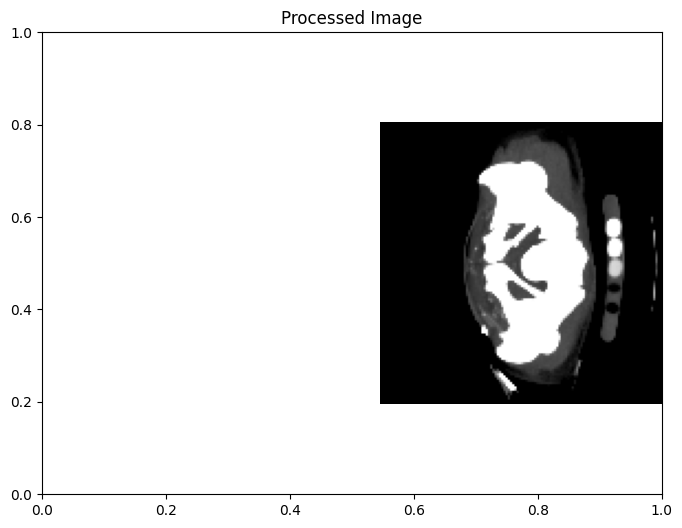

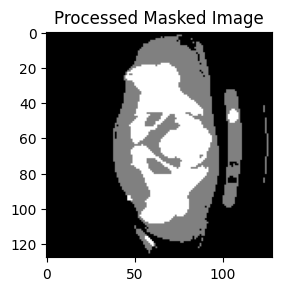

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


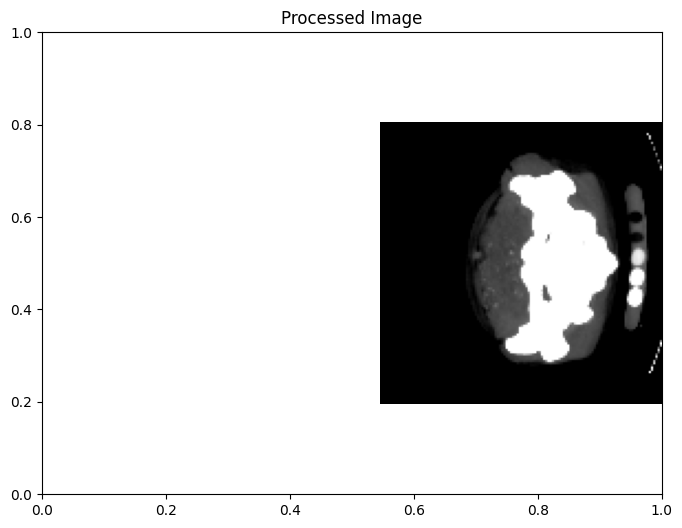

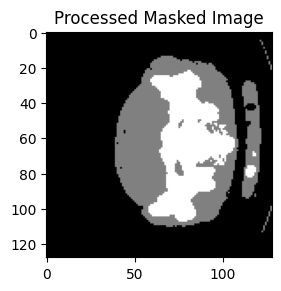

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


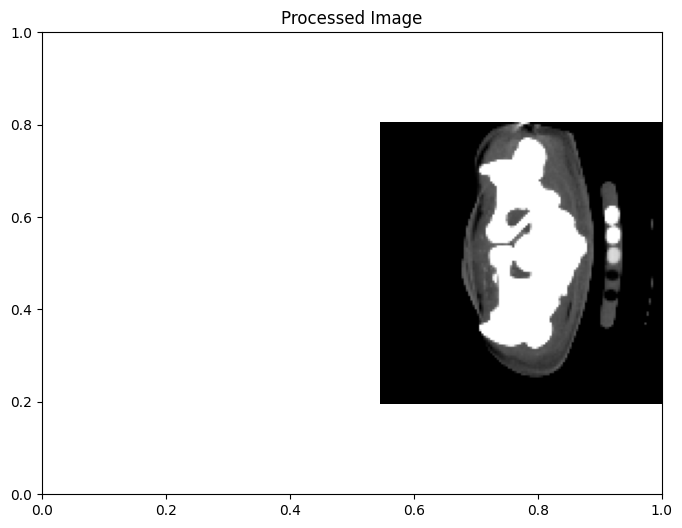

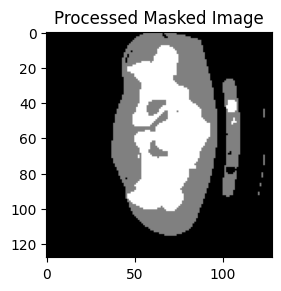

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


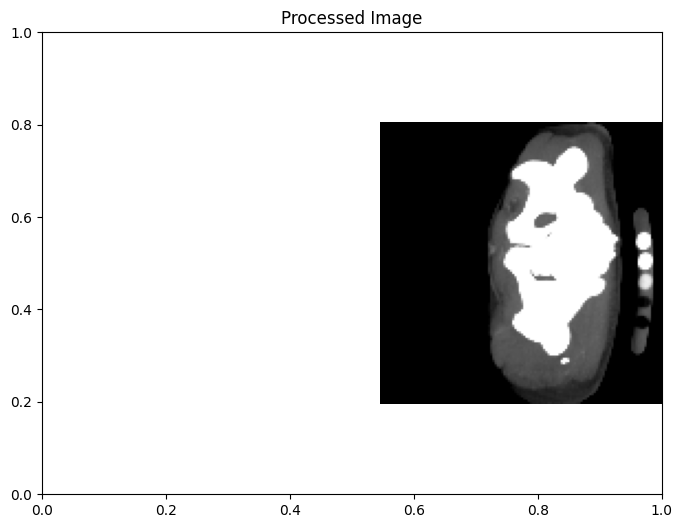

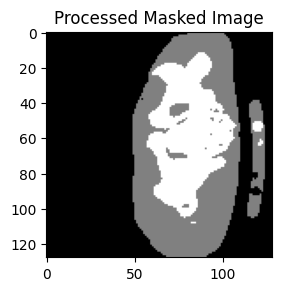

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


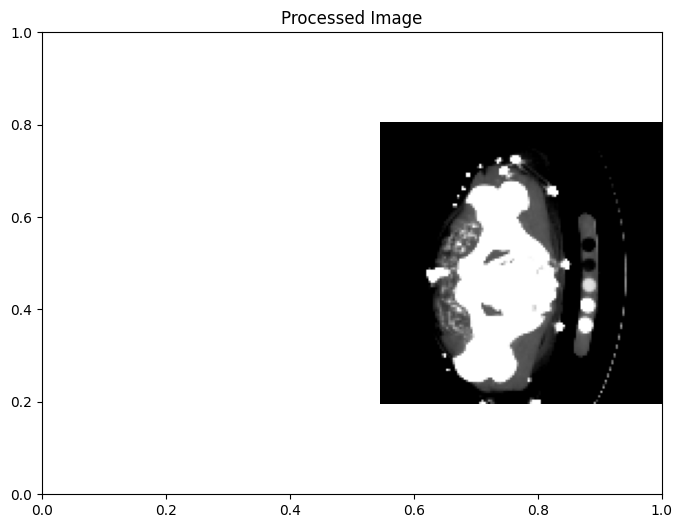

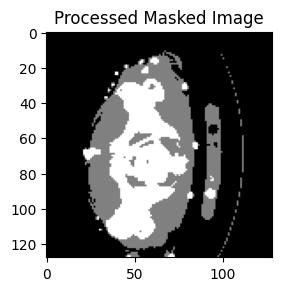

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


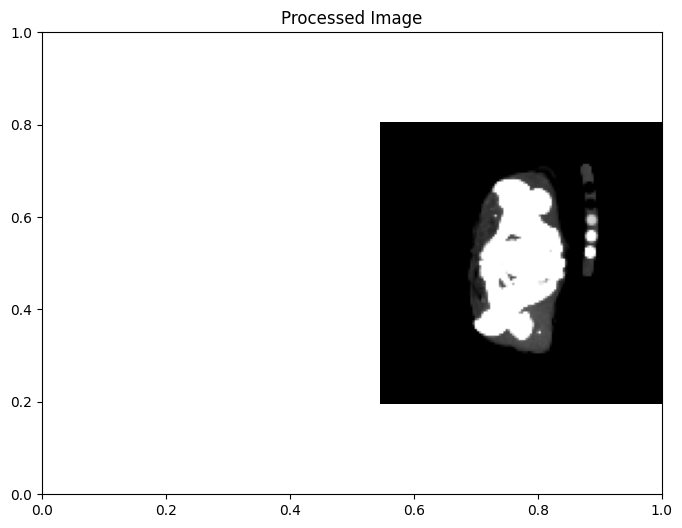

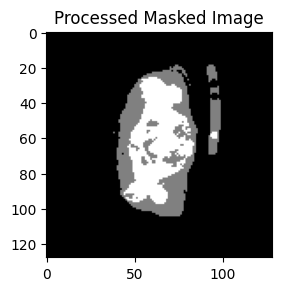

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


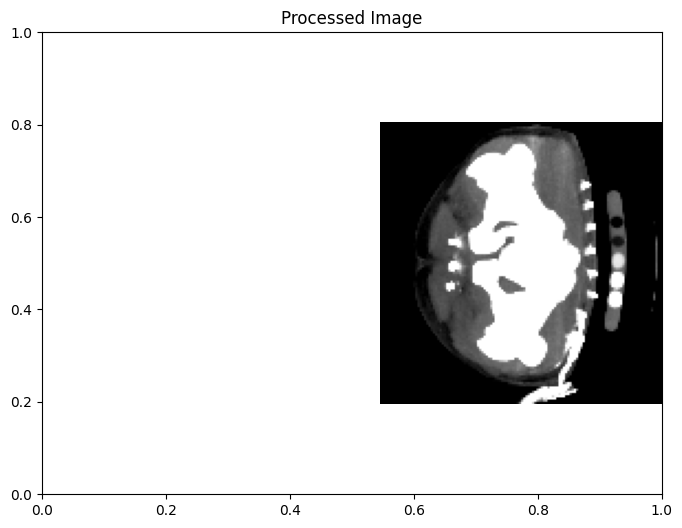

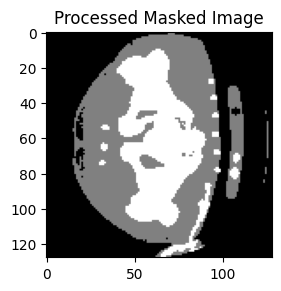

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


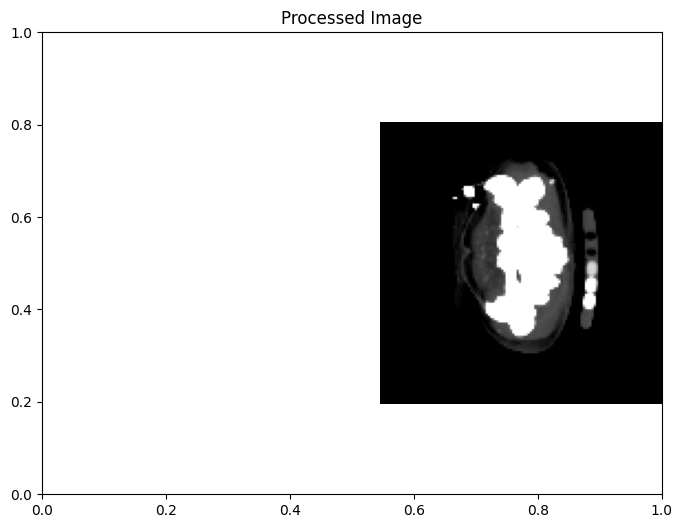

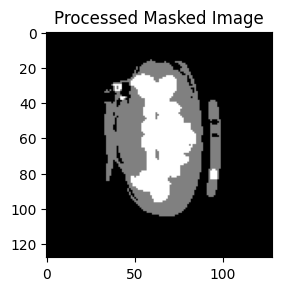

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


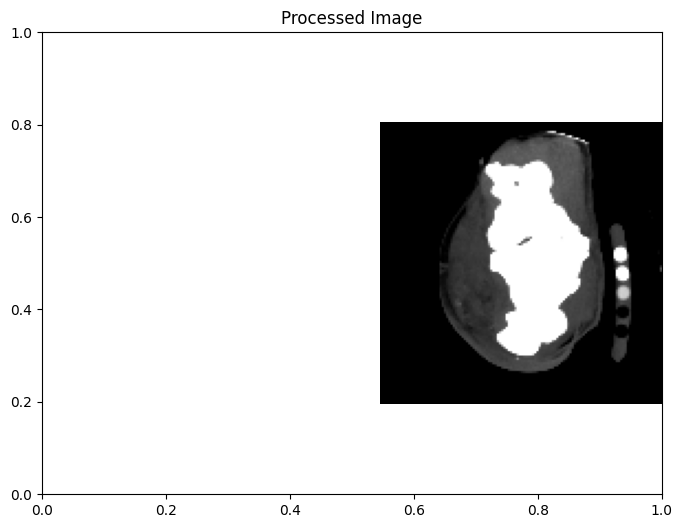

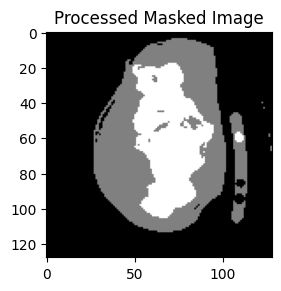

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


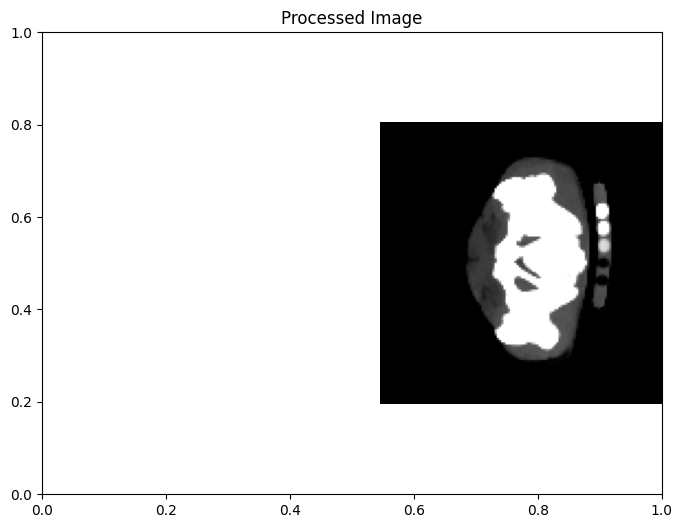

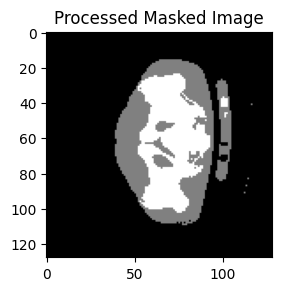

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


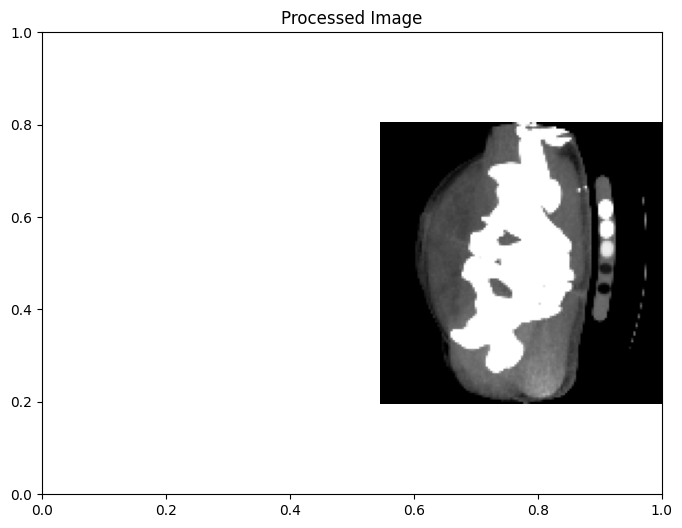

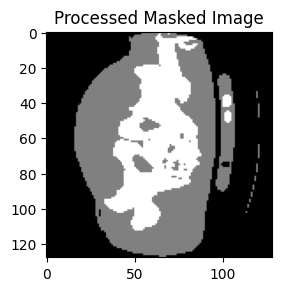

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


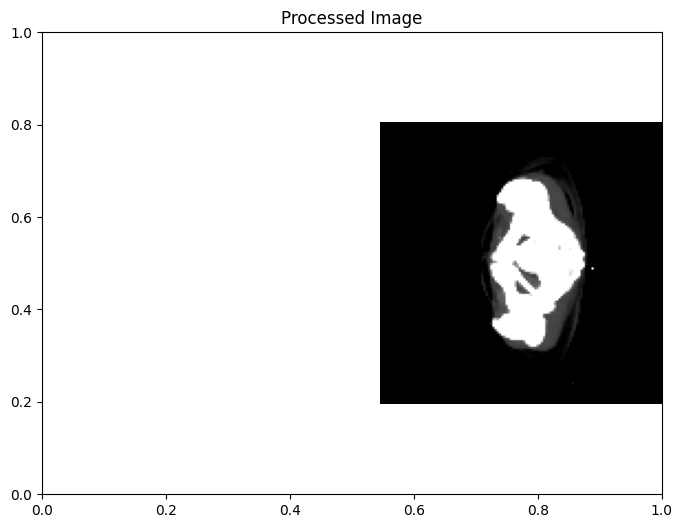

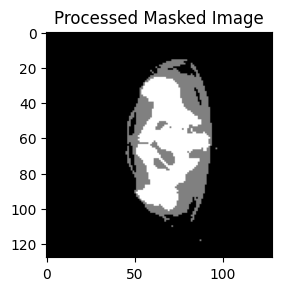

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


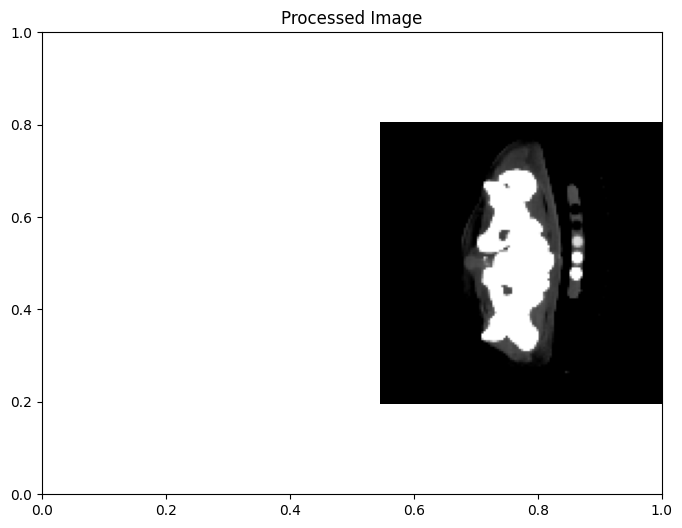

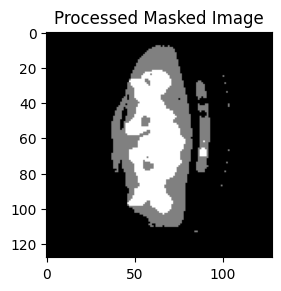

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


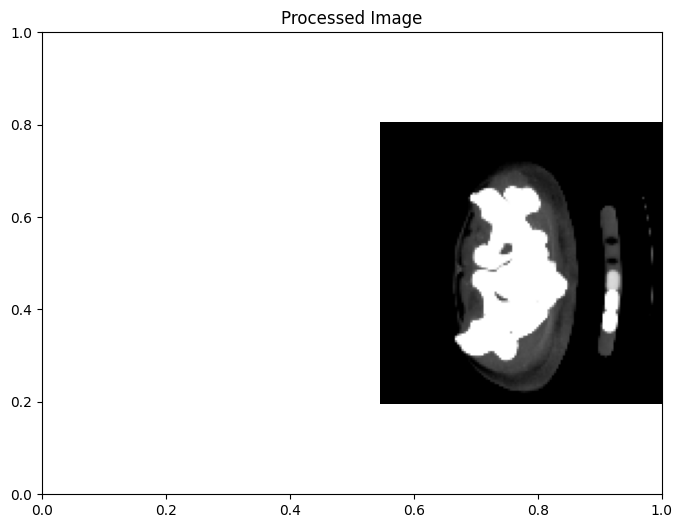

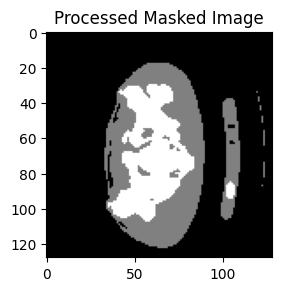

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


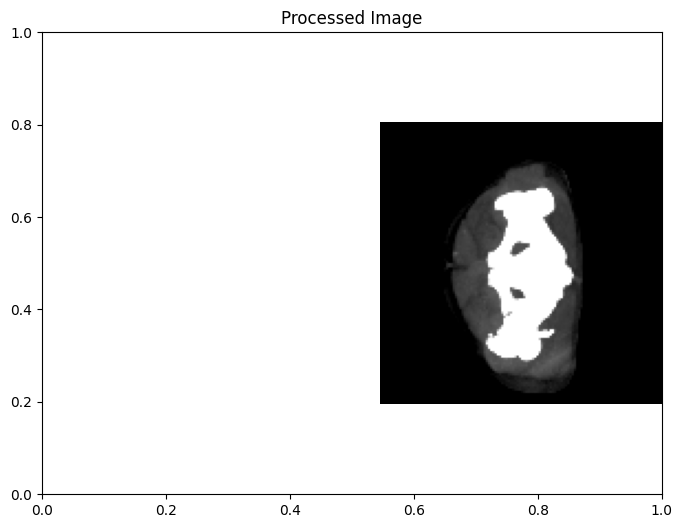

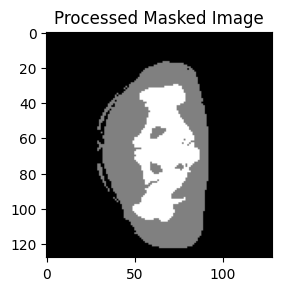

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


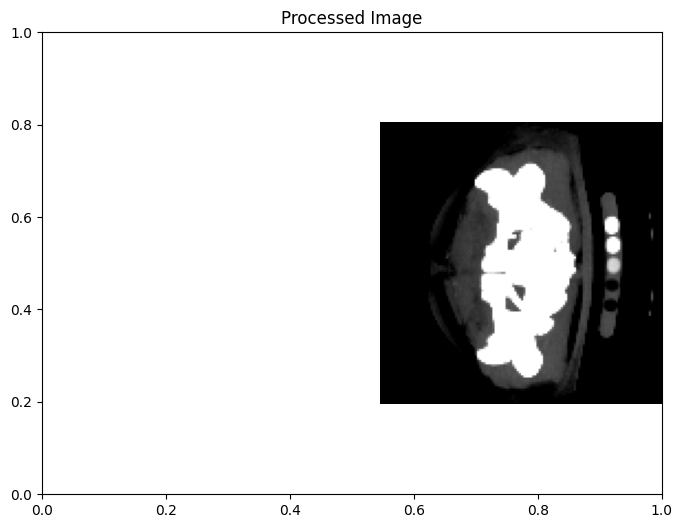

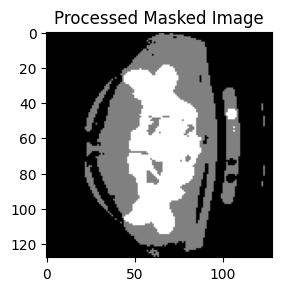

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


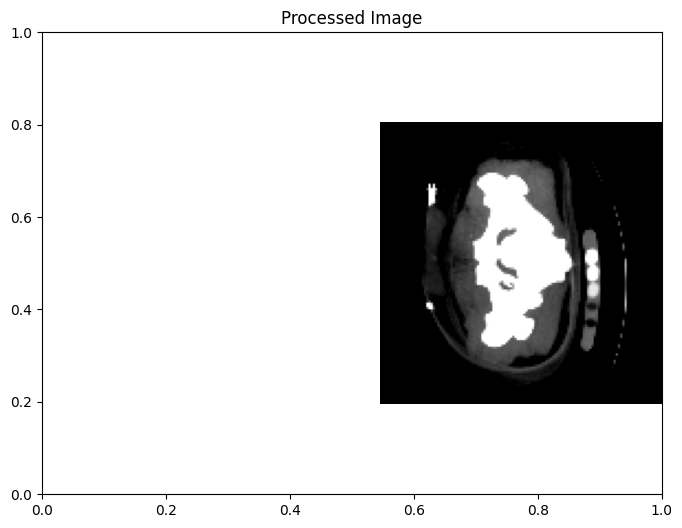

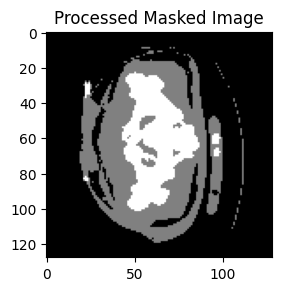

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


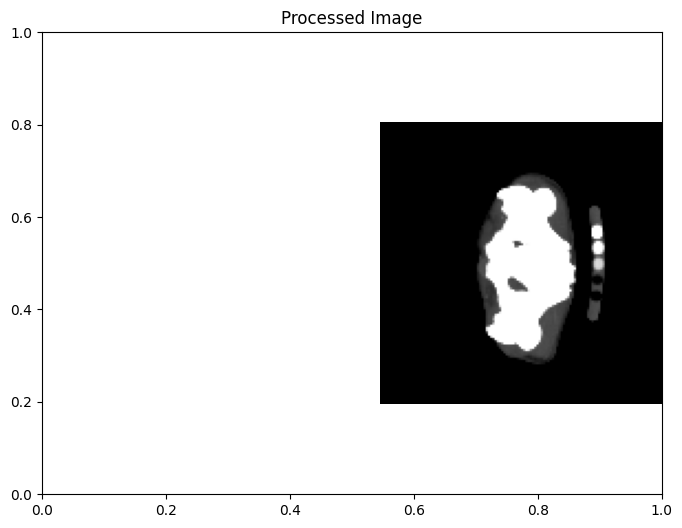

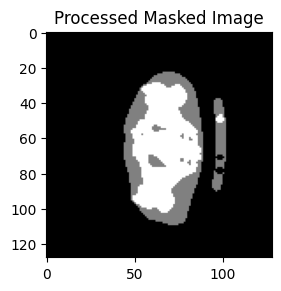

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


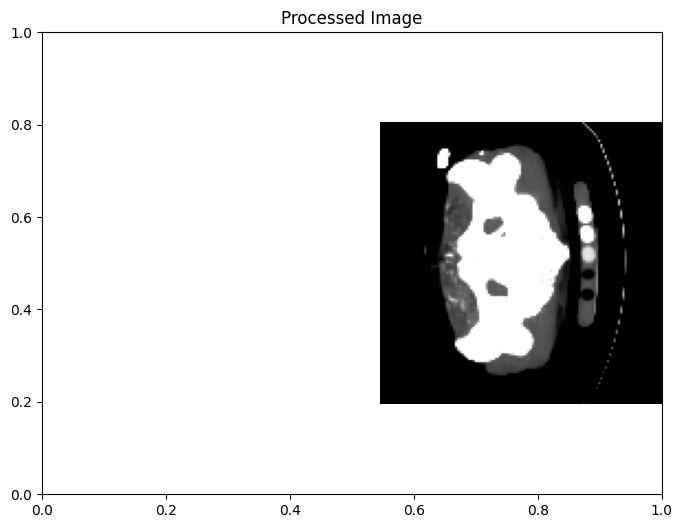

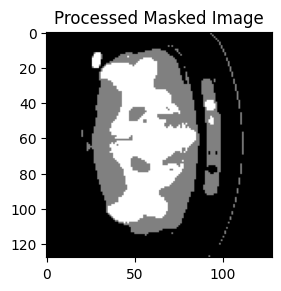

Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


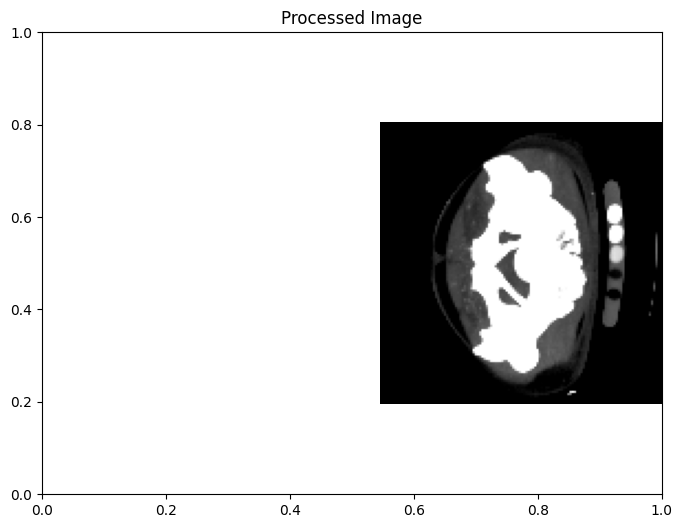

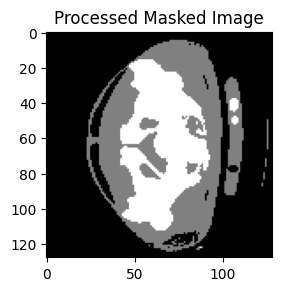

In [12]:

# There are 3 classes : background, pet, outline


# Visualize the output
for i in range(len(img)):
        plt.figure(figsize=(8, 6))
        plt.title('Processed Image')
        plt.subplot(1, 2, 2)
        plt.imshow(X[i])
        plt.axis('off')
        plt.show()

        plt.subplot(1, 2, 2)
        plt.title('Processed Masked Image')
        plt.imshow(y[i],cmap='gray')
        plt.show()


In [13]:
# Use scikit-learn's function to split the dataset
# Here, I have used 20% data as test/valid set
X_train, X_valid, y_train, y_valid = train_test_split(X, y, test_size=0.2, random_state=100)

In [14]:
print("X_train shape:", X_train.shape)
print("X_valid shape:", X_valid.shape)
print("y_train shape:", y_train.shape)
print("y_valid shape:", y_valid.shape)

X_train shape: (16, 128, 128, 3)
X_valid shape: (4, 128, 128, 3)
y_train shape: (16, 128, 128, 1)
y_valid shape: (4, 128, 128, 1)


In [15]:
# Call the helper function for defining the layers for the model, given the input image size
unet = UNetCompiled(input_size=(128,128,3), n_filters=32, n_classes=3)

In [16]:
# Check the summary to better interpret how the output dimensions change in each layer
unet.summary()

Model: "model"
__________________________________________________________________________________________________
 Layer (type)                   Output Shape         Param #     Connected to                     
 input_1 (InputLayer)           [(None, 128, 128, 3  0           []                               
                                )]                                                                
                                                                                                  
 conv2d (Conv2D)                (None, 128, 128, 32  896         ['input_1[0][0]']                
                                )                                                                 
                                                                                                  
 conv2d_1 (Conv2D)              (None, 128, 128, 32  9248        ['conv2d[0][0]']                 
                                )                                                             

 conv2d_15 (Conv2D)             (None, 64, 64, 64)   36928       ['conv2d_14[0][0]']              
                                                                                                  
 conv2d_transpose_3 (Conv2DTran  (None, 128, 128, 32  18464      ['conv2d_15[0][0]']              
 spose)                         )                                                                 
                                                                                                  
 concatenate_3 (Concatenate)    (None, 128, 128, 64  0           ['conv2d_transpose_3[0][0]',     
                                )                                 'batch_normalization[0][0]']    
                                                                                                  
 conv2d_16 (Conv2D)             (None, 128, 128, 32  18464       ['concatenate_3[0][0]']          
                                )                                                                 
          

In [25]:
# There are multiple optimizers, loss functions and metrics that can be used to compile multi-class segmentation models
# Ideally, try different options to get the best accuracy
unet.compile(optimizer=tf.keras.optimizers.Adam(),
             loss=tf.keras.losses.SparseCategoricalCrossentropy(),
              metrics=['accuracy'])

In [26]:
# Run the model in a mini-batch fashion and compute the progress for each epoch
results = unet.fit(X_train, y_train, batch_size=32, epochs=20, validation_data=(X_valid, y_valid))

Epoch 1/20
1/1 [==============================] - 11s 11s/step - loss: 0.6828 - accuracy: 0.7627 - val_loss: 1.1636 - val_accuracy: 0.7799
Epoch 2/20
1/1 [==============================] - 3s 3s/step - loss: 1.1423 - accuracy: 0.7596 - val_loss: 0.9320 - val_accuracy: 0.8277
Epoch 3/20
1/1 [==============================] - 3s 3s/step - loss: 0.8951 - accuracy: 0.8121 - val_loss: 1.0118 - val_accuracy: 0.8353
Epoch 4/20
1/1 [==============================] - 3s 3s/step - loss: 1.0074 - accuracy: 0.8193 - val_loss: 0.6458 - val_accuracy: 0.8242
Epoch 5/20
1/1 [==============================] - 3s 3s/step - loss: 0.6493 - accuracy: 0.8048 - val_loss: 0.9440 - val_accuracy: 0.8199
Epoch 6/20
1/1 [==============================] - 3s 3s/step - loss: 0.9302 - accuracy: 0.7979 - val_loss: 0.4911 - val_accuracy: 0.8115
Epoch 7/20
1/1 [==============================] - 3s 3s/step - loss: 0.5171 - accuracy: 0.7856 - val_loss: 0.4688 - val_accuracy: 0.8051
Epoch 8/20
1/1 [=======================

In [61]:
unet.evaluate(X_valid, y_valid)


1/1 [==============================] - 0s 250ms/step - loss: 0.4845 - accuracy: 0.8766


[0.48445549607276917, 0.8766021728515625]

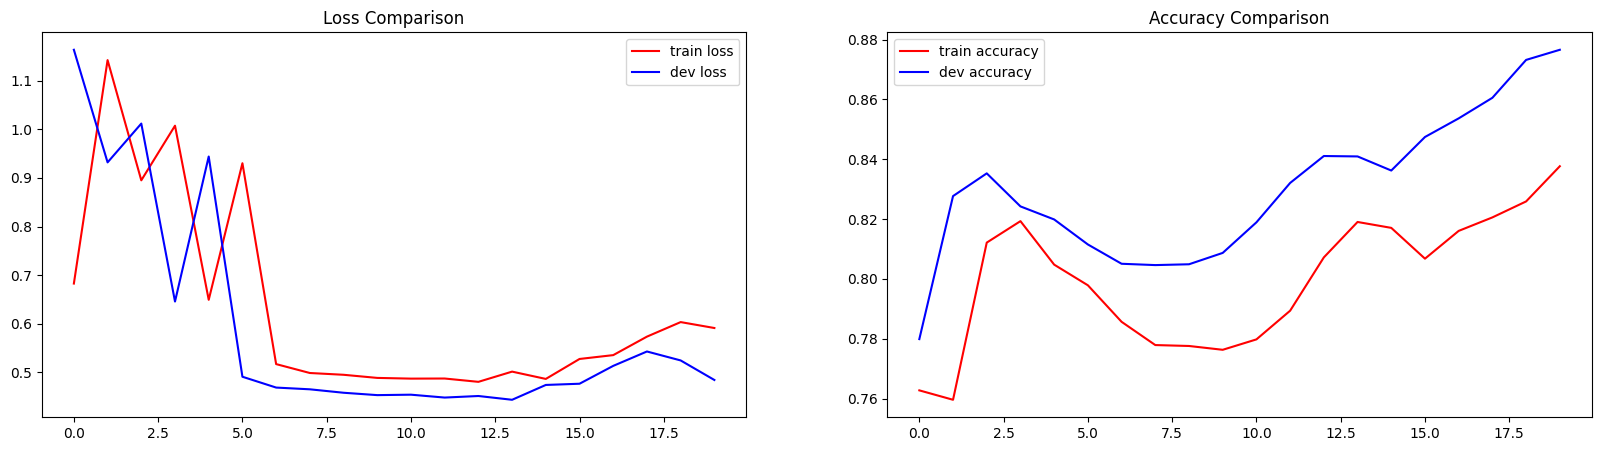

In [28]:
# High Bias is a characteristic of an underfitted model and we would observe low accuracies for both train and validation set
# High Variance is a characterisitic of an overfitted model and we would observe high accuracy for train set and low for validation set
# To check for bias and variance plit the graphs for accuracy
# I have plotted for loss too, this helps in confirming if the loss is decreasing with each iteration - hence, the model is optimizing fine
fig, axis = plt.subplots(1, 2, figsize=(20, 5))
axis[0].plot(results.history["loss"], color='r', label = 'train loss')
axis[0].plot(results.history["val_loss"], color='b', label = 'dev loss')
axis[0].set_title('Loss Comparison')
axis[0].legend()
axis[1].plot(results.history["accuracy"], color='r', label = 'train accuracy')
axis[1].plot(results.history["val_accuracy"], color='b', label = 'dev accuracy')
axis[1].set_title('Accuracy Comparison')
axis[1].legend()

# RESULTS
# The train loss is consistently decreasing showing that Adam is able to optimize the model and find the minima
# The accuracy of train and validation is ~90% which is high enough, so low bias
# and the %s aren't that far apart, hence low variance

In [29]:
unet.evaluate(X_valid, y_valid)


1/1 [==============================] - 0s 250ms/step - loss: 0.4845 - accuracy: 0.8766


[0.48445549607276917, 0.8766021728515625]

1/1 [==============================] - 0s 109ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Confusion Matrix:
[[13022     2     0]
 [  806   357   328]
 [   50   137  1682]]


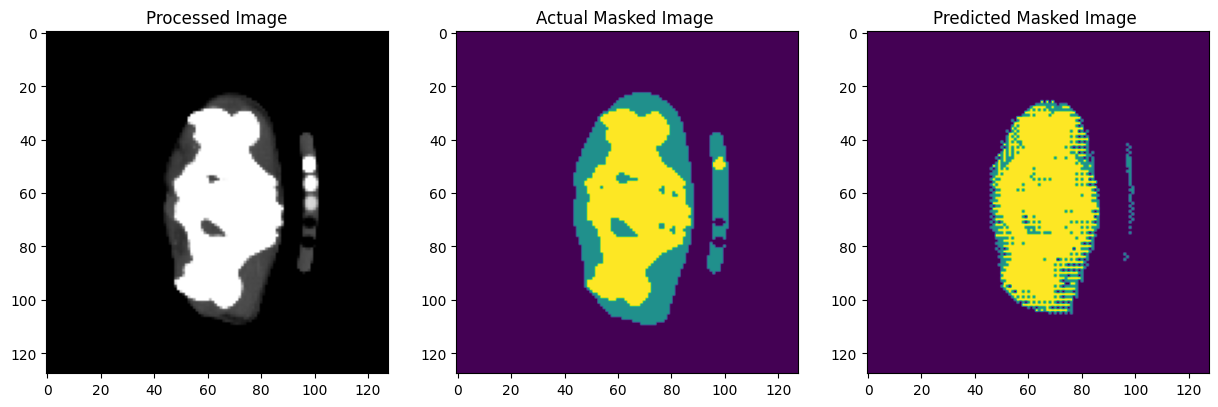

In [56]:
# Plot confusion matrix
import numpy as np
from sklearn.metrics import confusion_matrix

def VisualizeResults(index):
    img = X_valid[index]
    img = img[np.newaxis, ...]
    pred_y = unet.predict(img)
    pred_mask = tf.argmax(pred_y[0], axis=-1)
    pred_mask = pred_mask[..., tf.newaxis]

    # Convert tensors to NumPy arrays
    actual_mask_flat = np.asarray(y_valid[index].flatten())
    pred_mask_flat = np.asarray(pred_mask.numpy().flatten())

    # Compute confusion matrix
    confusion_mat = confusion_matrix(actual_mask_flat, pred_mask_flat)

    fig, arr = plt.subplots(1, 3, figsize=(15, 15))
    arr[0].imshow(X_valid[index])
    arr[0].set_title('Processed Image')
    arr[1].imshow(y_valid[index,:,:,0])
    arr[1].set_title('Actual Masked Image ')
    arr[2].imshow(pred_mask[:,:,0])
    arr[2].set_title('Predicted Masked Image ')

    return pred_mask[:,:,0], confusion_mat

# Example usage:
index = 0  # Set the index of the image you want to visualize
pred_mask, confusion_mat = VisualizeResults(index)
print("Confusion Matrix:")
print(confusion_mat)

1/1 [==============================] - 0s 125ms/step


Clipping input data to the valid range for imshow with RGB data ([0..1] for floats or [0..255] for integers).


Confusion Matrix:
[[13022     2     0]
 [  806   357   328]
 [   50   137  1682]]


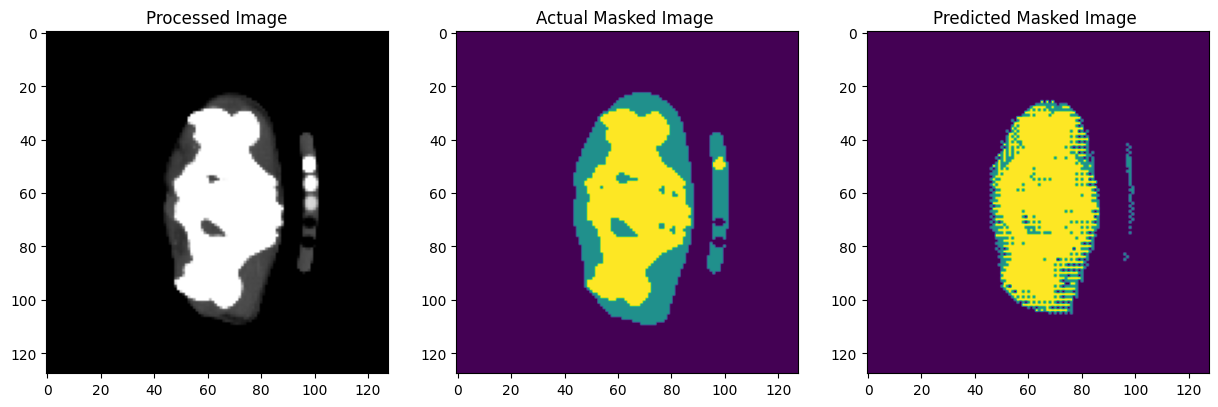

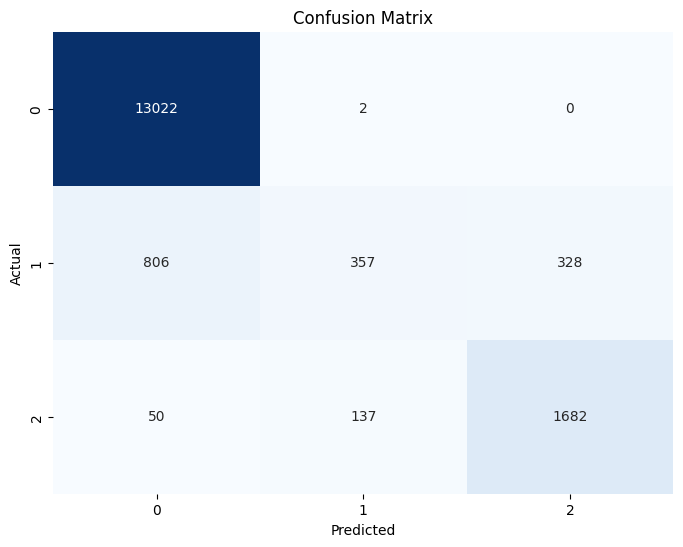

In [59]:
import matplotlib.pyplot as plt
import seaborn as sns

# Define a function to display confusion matrix as heatmap
def display_confusion_matrix(confusion_mat):
    plt.figure(figsize=(8, 6))
    sns.heatmap(confusion_mat, annot=True, fmt="d", cmap="Blues", cbar=False)
    plt.xlabel("Predicted")
    plt.ylabel("Actual")
    plt.title("Confusion Matrix")
    plt.show()

# Example usage:
index = 0  # Set the index of the image you want to visualize
pred_mask, confusion_mat = VisualizeResults(index)

# Display confusion matrix
print("Confusion Matrix:")
print(confusion_mat)
display_confusion_matrix(confusion_mat)

(100, 128, 128)


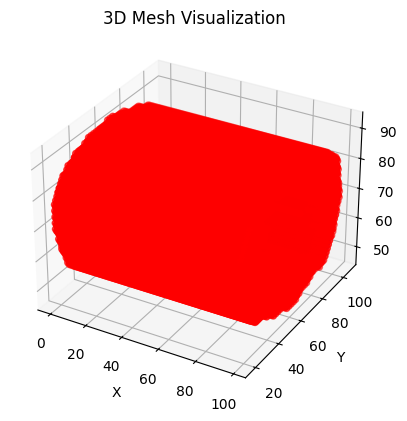

In [60]:
import skimage.measure

# Load the 2D CT image mask (assuming it's represented as a numpy array)

# Assuming ctmaskar is a 2D numpy array representing the CT image mask
ctmaskar_3d = np.expand_dims(ctmaskar, axis=0)  # Add a singleton dimension along the first axis

# You may repeat this 2D mask along the third dimension to create a 3D volume
depth = 100  # Depth of the 3D volume
ctmaskar_3d = np.repeat(ctmaskar_3d, depth, axis=0)

# You can print the shape to verify it's a 3D array
print(ctmaskar_3d.shape)
# Apply the marching cubes algorithm
vertices, triangles, _, _ = skimage.measure.marching_cubes(ctmaskar_3d, level=0)
# Create the 3D mesh
mesh = {
    'vertices': vertices,  # Array of vertex coordinates
    'faces': triangles  # Array of indices defining triangles
}

# Create a new figure
fig = plt.figure()
ax = fig.add_subplot(111, projection='3d')

# Plot the vertices
ax.scatter(vertices[:, 0], vertices[:, 1], vertices[:, 2], c='r', marker='o')

# Plot the triangles
for triangle in triangles:
    # Get the vertex coordinates for this triangle
    x = vertices[triangle, 0]
    y = vertices[triangle, 1]
    z = vertices[triangle, 2]

    # Close the triangle by appending the first vertex again
    x = np.append(x, x[0])
    y = np.append(y, y[0])
    z = np.append(z, z[0])

    # Plot the triangle
    ax.plot(x, y, z, color='b')

# Set labels and title
ax.set_xlabel('X')
ax.set_ylabel('Y')
ax.set_zlabel('Z')
ax.set_title('3D Mesh Visualization')

# Show the plot
plt.show()